# Artem Moskalev. Convolutional neural networks for semantic segmentation

## Get the data 

Here's a link to the tar with the dataset splitted into train and validation set. Execute the following lines or download and unpack the archive manually. 

In [1]:
! wget https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0 -O data.tar.gz
! tar -zxf data.tar.gz

--2018-04-18 20:06:11--  https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/X1vfSyaMcfEXUxox8JMAM4BYfeO2lGVtoPNUO5BGoCrE5r2MmNbzcYz3rt2vtdn4/file [following]
--2018-04-18 20:06:12--  https://dl.dropboxusercontent.com/content_link/X1vfSyaMcfEXUxox8JMAM4BYfeO2lGVtoPNUO5BGoCrE5r2MmNbzcYz3rt2vtdn4/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6, 2620:100:6022:6::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68519950 (65M) [application/octet-stream]
Saving to: ‘data.tar.gz’

100%[======================================>] 68 519 950  10,9MB/s   in 6,3s   

2018-

## Introduction

The problem offered to you is multi-class semantic segmentation. We provide you with an implementation of a Dataset file and a couple of handy transforms that will save you some time. You will have to code your own augmentations though -- for this task they will likely be slightly different. 

The evaluation metric for this problem is unweighted Mean Intersection over Union (mIoU) over all classes. But we ask you to report not only the mIoU score, but also IoU scores for each class. 

## Dataset 

This is a 4x-downsampled version of HumanParsing dataset, with all original labels merged into three groups:

    1. Background
    2. Clothes
    3. Body part
    
Each photo is a 150x100 RGB image.
  
This problem is more complex than image classification and is computationally intensive. Design you experiment accordingly, aiming as quick feedback on your ideas. It's time to apply every method and trick you've learned during the course. To achieve higher scores we suggest the following:

    1. Read more about multi-class segmentation nets and state of the art convolutional encoder-decoders
    2. User pretrained (at least, partially) networks for encoding
    3. Try some augmentation (look into torchvision package)
    4. Experiment with learning rate, scheduled learning rate and class weighting. 
    
The classes are imbalanced, although less so than they are in the real dataset. You will need to come up with a way to mitigate that.


## Grading

60% - 0.6 mIoU
70% - 0.7 mIoU
80% - 0.8 mIoU

Remaining 20% will be given for the quality of the report and deep analysis.

In [25]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import time 

import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
import torch.nn.functional as F
from torchvision import transforms
%matplotlib inline

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


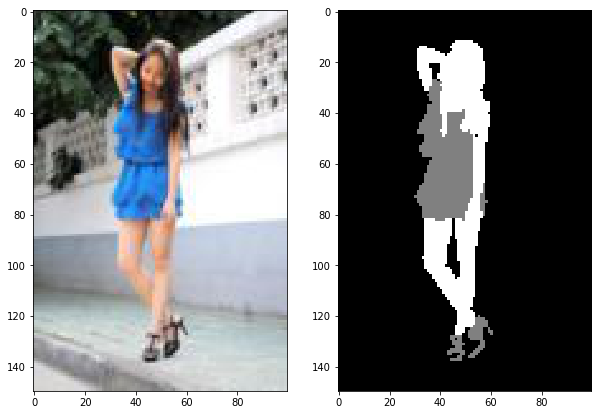

In [26]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('humanparsing-4x/valid/imgs/997_399.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('humanparsing-4x/valid/maps/997_399.png')
plt.imshow(mask, 'gray');

In [4]:
from humanparsing import HumanParsing, fast_hist, per_class_iu
from torch.utils.data import DataLoader

In [5]:
#train_transforms = [transforms.RandomHorizontalFlip()]
#train_transforms = [transforms.RandomSizedCrop(size=(150,100)),transforms.RandomHorizontalFlip()]

In [6]:
train_data = HumanParsing(data_dir='./humanparsing-4x/train/', augmentation=None)
valid_data = HumanParsing(data_dir='./humanparsing-4x/valid/', augmentation=None)

print('{} images in train set, {} in validation set'.format(len(train_data), len(valid_data)))

batch_size = 16

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=1)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=1, num_workers=0)

14533 images in train set, 1615 in validation set


#### Building a net

In [7]:
import torch
from torch import nn

class downstream_block(nn.Module):
    def __init__(self, in_dim=None, out_dim=None, kernel_dim=3, kernel_padding=1, ceil_mode=False):
        super(downstream_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_dim, padding=kernel_padding)
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_dim, padding=kernel_padding)
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.relu2 = nn.LeakyReLU()
        self.mp = nn.MaxPool2d(2, ceil_mode=ceil_mode)
        
    def forward(self, x):
        x = self.mp(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x
    
class upstream_block(nn.Module):
    def __init__(self, in_dim=None, out_dim=None, kernel_dim=3, kernel_padding=1, size=None):
        super(upstream_block, self).__init__()
        
        if size is None:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.Upsample(size=size,mode='bilinear')
        
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_dim, padding=kernel_padding)
        self.bn1 = nn.BatchNorm2d(out_dim)
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_dim, padding=kernel_padding)
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.relu2 = nn.LeakyReLU()
        
    def forward(self, FM1, FM2):
        x = self.up(FM1)
        x = self.conv1(torch.cat((x,FM2), dim=1))
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        return x

class Vanilla_UNet(nn.Module):
    def __init__(self):
        super(Vanilla_UNet, self).__init__()
        
        self.inconv1 = nn.Conv2d(3, out_channels=32, kernel_size=3, padding=1)
        self.inconv2 = nn.Conv2d(32,32,3, padding=1)
        
        self.down1 = downstream_block(32,64)
        self.down2 = downstream_block(64,128)
        self.down3 = downstream_block(128,256)
        self.down4 = downstream_block(256,256)
        
        self.up1 = upstream_block(512, 128)
        self.up2 = upstream_block(256,64, size=(37, 25))
        self.up3 = upstream_block(128,32, size=(75, 50))
        self.up4 = upstream_block(64,32)
        
        self.outconv = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)
        #self.sm = nn.Softmax2d()
        
    def forward(self, x):
        
        x_in = self.inconv2(self.inconv1(x))
        
        x1 = self.down1(x_in)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        x = self.up1(FM1=x4, FM2=x3)
        x = self.up2(FM1=x, FM2=x2)
        x = self.up3(FM1=x, FM2=x1)
        x = self.up4(FM1=x, FM2=x_in)
        
        x = self.outconv(x)
        #x = self.sm(x)
        return x

In [8]:
net = Vanilla_UNet().cuda()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

 - ##### Difine the loss:

I suggest to use an ensemble of 2 U-Nets: for clothes and for body. Thus, we will have to define to separate pipelines:

In [9]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch).cuda())
    y_batch = Variable(torch.LongTensor(y_batch).cuda())
    logits = net(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

 - ##### Train U-Net:

In [10]:
num_epochs = 15
val_loss, train_loss = [],[]
for epoch in tqdm_notebook(range(num_epochs)):
    
    start_time = time.time()
    net.train(True)
    for X_batch, y_batch in train_loader:

        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
        
    if (epoch+1)%8==0:
        opt.param_groups[0]['lr'] = opt.param_groups[0]['lr']/20
    
    net.train(False) 
    for X_batch, y_batch in valid_loader:
        loss = compute_loss(X_batch, y_batch)
        val_loss.append(loss.cpu().data.numpy()[0])

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  validation loss: \t\t\t{:.2f} %".format(
        np.mean(val_loss[-len(valid_loader) // batch_size :]) * 100))

A Jupyter Widget

Epoch 1 of 15 took 106.728s
  training loss (in-iteration): 	0.181199
  validation loss: 			18.56 %
Epoch 2 of 15 took 108.637s
  training loss (in-iteration): 	0.154524
  validation loss: 			13.77 %
Epoch 3 of 15 took 107.500s
  training loss (in-iteration): 	0.131118
  validation loss: 			13.33 %
Epoch 4 of 15 took 107.488s
  training loss (in-iteration): 	0.124681
  validation loss: 			12.60 %
Epoch 5 of 15 took 108.174s
  training loss (in-iteration): 	0.114155
  validation loss: 			10.57 %
Epoch 6 of 15 took 107.687s
  training loss (in-iteration): 	0.109854
  validation loss: 			10.42 %
Epoch 7 of 15 took 107.178s
  training loss (in-iteration): 	0.099319
  validation loss: 			10.59 %
Epoch 8 of 15 took 107.124s
  training loss (in-iteration): 	0.096648
  validation loss: 			10.28 %
Epoch 9 of 15 took 108.265s
  training loss (in-iteration): 	0.083012
  validation loss: 			8.90 %
Epoch 10 of 15 took 107.878s
  training loss (in-iteration): 	0.080792
  validation loss: 			8.82 %
E

 - ##### Test U-Net:

In [11]:
def fast_hist(pred, label, n=3):
    # pred, label -- flattened numpy arrays containing label ids for each pixel
    k = (label >= 0) & (label < n)
    return np.bincount(n * label[k].astype(int) + pred[k], minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))

In [12]:
net.train(False) 

per_class_IoU = list()

for X_batch, y_batch in valid_loader:
    pred = net(Variable(X_batch.cuda(), volatile=True))
    pred = pred.max(1)[1].cpu().data.numpy()

    per_class_IoU.append(per_class_iu(fast_hist(pred, y_batch.numpy())))

per_class_IoU = np.array(per_class_IoU)

In [13]:
print('mean IoU:', np.mean(per_class_IoU))

mean IoU: 0.845603406528076


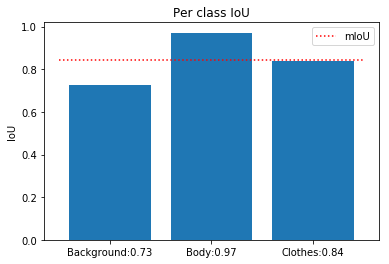

In [24]:
plt.bar(['Body:'+str(round(mIoUpc[0],2)),'Clothes:'+str(round(mIoUpc[1],2)),'Background:'+str(round(mIoUpc[2],2))],height = np.mean(per_class_IoU, axis=0))
plt.hlines(y=np.mean(per_class_IoU), xmin=-0.5, xmax=2.5, colors='r', linestyles=':', label='mIoU')
plt.title('Per class IoU')
plt.legend()
plt.ylabel('IoU');

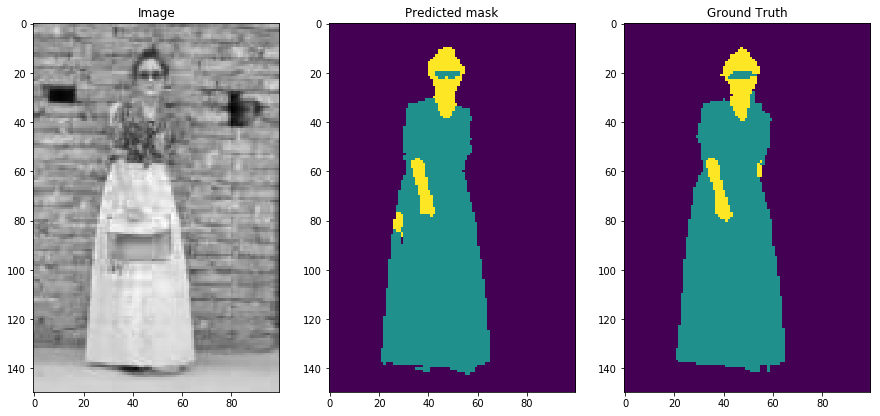

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].imshow(X_batch.numpy()[0,0,...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(pred[0,...])
ax[1].set_title('Predicted mask')
ax[2].imshow(y_batch.numpy()[0,...])
ax[2].set_title('Ground Truth');

## Report 

Hello, adventurer!

Today was a long day and I am finishing the fourth can of Red Bull. But it's fine, because there's nothing more exciting in the whole world than a noble quest for the best segmentation algorithm. Anyways, here's the story, and oh my, what a marvelous journey it was!..

### Preprocessing

From preprocessing, in the final model, nothing except default Normalization is used. I experimented with RandomResizeCrop and RandomHorizontalFlip, but because of specifics of humanparsing.py file, I constantly had errors and finally tried to manually load a dataset and warp it in PyTorch class and it was an even more huge pain to debug, so I ended with no specific augmentation.

### Methods

From the bare beginning, I was experimenting with two approaches. First is to build one U-Net for body segmentation and then, using weights from this network build one more U-Net for clothes and fine-tune it with no weights freezing. I used binary_cross_entropy as a loss here and on each iteration my $y_batch$ was just 2D tensor with 1's and 0's. It might have had worked good (and I bet would solve the problem of unbalanced classes), but slow and my patience was not unlimited, so I switched to the second approach. The second approach is more simple one is just to train one U-Net for everything, which I found is satisfactory in terms of speed of convergence and performance.

As for U-Net architecture, I just took vanilla U-Net from the paper but excluded fully connected layer on the bare 'bottom' of the network to accelerate it. I used 3x3 kernels everywhere because U-Net paper mentions this technique to be fruitful. As to the number of feature maps, I selected the maximum number of FM's that my GPU is able to process.

A number of epochs and learning rates were selected in the following way. Firstly, set $lr=10^-2$ and #epoches to 20. Then I noticed that network optimization stacks at 8-th epoch and loss does not decrease. That was a call to introduce learning rate decrease after that epoch. All other adjustments were done based on this logic.

As to batch size, I selected the maximum batch size that my GPU is able to handle.

### Conclusions

U-Net rules. I would also try to use dilated convolutions instead of maxpooling and would do this task with the first approach I described in `Methods`, but time runs fast.